[View in Colaboratory](https://colab.research.google.com/github/stikbuf/Language_Modeling/blob/master/Keras_Character_Aware_Neural_Language_Models.ipynb)

## Configure the cloud environment


### Mount Google Drive

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting

In [2]:
# If you got a "Transport endpoint is not connected." error. Please run this line first to unmount the drive.
# See https://stackoverflow.com/questions/49588113/google-colab-script-throws-transport-endpoint-is-not-connected?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
!fusermount -u drive

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
a = !ls drive/
print('Files in Drive:', a)
assert a!=[], 'Drive should not be empty!'

Files in Drive: ['share_with_me']


In [3]:
local_path='./drive/share_with_me/AI/Character-aware_LM/'
#local_path='./'
import sys
sys.path.append(local_path)
!ls './drive/share_with_me/AI/Character-aware_LM/'

Character-Aware Neural Language Models.ipynb
data
data_loader.py
Keras - Character-Aware Neural Language Models.ipynb
__pycache__
reader.py


In [4]:
import tensorflow as tf
#assert tf.test.gpu_device_name() != '', "GPU not avaliable!"
tf.test.gpu_device_name()

'/device:GPU:0'

## Load data

In [0]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from reader import ptb_raw_data, ptb_producer # by Google

In [6]:
train_data, valid_data, test_data, word_to_id = ptb_raw_data(local_path + 'data')
id_to_word = dict((v, k) for k, v in word_to_id.items())
voc_size = len(id_to_word)
voc_size

10000

In [7]:
id_to_word[voc_size]='<START>'
id_to_word[voc_size+1]='<END>'
word_to_id = dict((v, k) for k, v in id_to_word.items())
voc_size = len(id_to_word)
voc_size

10002

In [8]:
word_id = pd.DataFrame.from_dict(word_to_id, orient='index').sort_values(by=0, ascending=True)
word_id.columns = ['id']
print(word_id.head())
print(word_id.tail())

       id
the     0
<unk>   1
<eos>   2
N       3
of      4
              id
ssangyong   9997
swapo       9998
wachter     9999
<START>    10000
<END>      10001


In [9]:
id_word = pd.DataFrame.from_dict(id_to_word, orient='index')
id_word.columns = ['word']
print(id_word.head())
print(id_word.tail())

    word
0    the
1  <unk>
2  <eos>
3      N
4     of
            word
9997   ssangyong
9998       swapo
9999     wachter
10000    <START>
10001      <END>


In [10]:
' '.join([id_to_word[id] for id in train_data[:30]])

'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old'

## RNN baseline

In [0]:
import random
seq_len = 35

from tensorflow.python.keras.utils import to_categorical # 源码值得一读

def gen_word_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<START>']] + data[i:i+seq_len] + [word_to_id['<END>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            #print(X.shape)
            cnt += batch_size
            yield X, Y

In [12]:
t = np.array([[1,0,1],[0,1,0]], dtype=int)
to_categorical(t, num_classes=2)

array([[[0., 1.],
        [1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.],
        [1., 0.]]])

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU, Dense, Embedding, InputLayer
from tensorflow.python.keras.optimizers import RMSprop

In [0]:
model = Sequential()

embedding_size = 8


model.add(Embedding(input_dim=voc_size,
                    output_dim=embedding_size,
                    input_length=seq_len+1,
                    name='inputEmbedding'))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4, return_sequences=True))
model.add(Dense(voc_size, activation='softmax'))

In [0]:
# perplexity
def PPL(y_true, y_pred):
    return tf.exp(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

def ACC(y_true, y_pred):
    ACC = tf.equal(tf.argmax(y_true, axis = 2), 
                   tf.argmax(y_pred, axis = 2))
    ACC = tf.cast(ACC, tf.float32)

    return tf.reduce_mean(ACC)

In [0]:
optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[ACC, PPL])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputEmbedding (Embedding)   (None, 36, 8)             80016     
_________________________________________________________________
gru_1 (GRU)                  (None, 36, 8)             408       
_________________________________________________________________
gru_2 (GRU)                  (None, 36, 4)             156       
_________________________________________________________________
dense_1 (Dense)              (None, 36, 10002)         50010     
Total params: 130,590
Trainable params: 130,590
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=100,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/100
50/50 [==============================] - 33s 661ms/step - loss: 6.1502 - ACC: 0.1115 - PPL: 469.2248 - val_loss: 6.1831 - val_ACC: 0.1110 - val_PPL: 485.0262
Epoch 2/100
50/50 [==============================] - 32s 639ms/step - loss: 6.1498 - ACC: 0.1113 - PPL: 469.2274 - val_loss: 6.1751 - val_ACC: 0.1118 - val_PPL: 481.2219
Epoch 3/100
50/50 [==============================] - 32s 639ms/step - loss: 6.1353 - ACC: 0.1123 - PPL: 462.4761 - val_loss: 6.1728 - val_ACC: 0.1134 - val_PPL: 480.0445
Epoch 4/100
50/50 [==============================] - 32s 639ms/step - loss: 6.1332 - ACC: 0.1135 - PPL: 461.4985 - val_loss: 6.1846 - val_ACC: 0.1112 - val_PPL: 485.6040
Epoch 5/100
32/50 [==================>...........] - ETA: 8s - loss: 6.1226 - ACC: 0.1138 - PPL: 456.5889

50/50 [==============================] - 32s 639ms/step - loss: 6.1233 - ACC: 0.1134 - PPL: 456.8990 - val_loss: 6.1529 - val_ACC: 0.1133 - val_PPL: 470.6709
Epoch 6/100
50/50 [==============================] - 32s 639ms/step - loss: 6.1144 - ACC: 0.1134 - PPL: 452.7667 - val_loss: 6.1546 - val_ACC: 0.1143 - val_PPL: 471.5120
Epoch 7/100
50/50 [==============================] - 32s 637ms/step - loss: 6.0996 - ACC: 0.1163 - PPL: 446.2223 - val_loss: 6.1659 - val_ACC: 0.1120 - val_PPL: 476.6141
Epoch 8/100
50/50 [==============================] - 32s 638ms/step - loss: 6.1066 - ACC: 0.1150 - PPL: 449.3957 - val_loss: 6.1639 - val_ACC: 0.1137 - val_PPL: 475.8817
Epoch 9/100
40/50 [=======================>......] - ETA: 4s - loss: 6.1053 - ACC: 0.1158 - PPL: 448.7230

50/50 [==============================] - 32s 638ms/step - loss: 6.1078 - ACC: 0.1152 - PPL: 449.7795 - val_loss: 6.1318 - val_ACC: 0.1143 - val_PPL: 461.0848
Epoch 10/100
50/50 [==============================] - 32s 640ms/step - loss: 6.0937 - ACC: 0.1149 - PPL: 443.4350 - val_loss: 6.1369 - val_ACC: 0.1142 - val_PPL: 463.2851
Epoch 11/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0870 - ACC: 0.1153 - PPL: 440.6856 - val_loss: 6.1262 - val_ACC: 0.1147 - val_PPL: 458.2231
Epoch 12/100
50/50 [==============================] - 32s 638ms/step - loss: 6.0840 - ACC: 0.1143 - PPL: 439.4264 - val_loss: 6.1252 - val_ACC: 0.1157 - val_PPL: 457.7963
Epoch 13/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0810 - ACC: 0.1153 - PPL: 437.9151

50/50 [==============================] - 32s 638ms/step - loss: 6.0807 - ACC: 0.1153 - PPL: 437.7661 - val_loss: 6.1223 - val_ACC: 0.1158 - val_PPL: 456.6612
Epoch 14/100
50/50 [==============================] - 32s 638ms/step - loss: 6.0799 - ACC: 0.1154 - PPL: 437.5617 - val_loss: 6.1142 - val_ACC: 0.1149 - val_PPL: 452.7329
Epoch 15/100
50/50 [==============================] - 32s 638ms/step - loss: 6.0791 - ACC: 0.1158 - PPL: 437.0671 - val_loss: 6.1105 - val_ACC: 0.1154 - val_PPL: 451.0202
Epoch 16/100
50/50 [==============================] - 32s 640ms/step - loss: 6.0615 - ACC: 0.1160 - PPL: 429.3798 - val_loss: 6.0919 - val_ACC: 0.1159 - val_PPL: 442.6734
Epoch 17/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0720 - ACC: 0.1149 - PPL: 434.0397

50/50 [==============================] - 32s 639ms/step - loss: 6.0703 - ACC: 0.1154 - PPL: 433.2306 - val_loss: 6.0974 - val_ACC: 0.1157 - val_PPL: 445.1234
Epoch 18/100
50/50 [==============================] - 32s 637ms/step - loss: 6.0678 - ACC: 0.1164 - PPL: 432.5452 - val_loss: 6.0997 - val_ACC: 0.1151 - val_PPL: 446.1928
Epoch 19/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0598 - ACC: 0.1164 - PPL: 428.7515 - val_loss: 6.0879 - val_ACC: 0.1151 - val_PPL: 441.1335
Epoch 20/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0477 - ACC: 0.1168 - PPL: 423.5228 - val_loss: 6.0845 - val_ACC: 0.1172 - val_PPL: 439.4723
Epoch 21/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0513 - ACC: 0.1167 - PPL: 425.0055

50/50 [==============================] - 32s 638ms/step - loss: 6.0518 - ACC: 0.1167 - PPL: 425.3178 - val_loss: 6.1018 - val_ACC: 0.1157 - val_PPL: 447.1437
Epoch 22/100
50/50 [==============================] - 32s 640ms/step - loss: 6.0522 - ACC: 0.1150 - PPL: 425.5595 - val_loss: 6.0924 - val_ACC: 0.1152 - val_PPL: 442.9209
Epoch 23/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0502 - ACC: 0.1162 - PPL: 424.6779 - val_loss: 6.0973 - val_ACC: 0.1158 - val_PPL: 445.3396
Epoch 24/100
50/50 [==============================] - 32s 638ms/step - loss: 6.0326 - ACC: 0.1183 - PPL: 417.0608 - val_loss: 6.0986 - val_ACC: 0.1152 - val_PPL: 445.6640
Epoch 25/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0428 - ACC: 0.1167 - PPL: 421.6777

50/50 [==============================] - 32s 639ms/step - loss: 6.0444 - ACC: 0.1165 - PPL: 422.3805 - val_loss: 6.0957 - val_ACC: 0.1174 - val_PPL: 444.3320
Epoch 26/100
50/50 [==============================] - 32s 638ms/step - loss: 6.0440 - ACC: 0.1166 - PPL: 422.0863 - val_loss: 6.0889 - val_ACC: 0.1171 - val_PPL: 441.5564
Epoch 27/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0254 - ACC: 0.1169 - PPL: 414.1890 - val_loss: 6.0861 - val_ACC: 0.1161 - val_PPL: 440.2797
Epoch 28/100
50/50 [==============================] - 32s 636ms/step - loss: 6.0380 - ACC: 0.1169 - PPL: 419.4187 - val_loss: 6.0732 - val_ACC: 0.1165 - val_PPL: 434.5873
Epoch 29/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0282 - ACC: 0.1178 - PPL: 415.5042

50/50 [==============================] - 32s 638ms/step - loss: 6.0302 - ACC: 0.1177 - PPL: 416.3162 - val_loss: 6.0840 - val_ACC: 0.1178 - val_PPL: 439.2456
Epoch 30/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0314 - ACC: 0.1175 - PPL: 416.7431 - val_loss: 6.0802 - val_ACC: 0.1171 - val_PPL: 437.5931
Epoch 31/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0288 - ACC: 0.1195 - PPL: 415.7878 - val_loss: 6.0684 - val_ACC: 0.1174 - val_PPL: 432.3878
Epoch 32/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0327 - ACC: 0.1182 - PPL: 417.3174 - val_loss: 6.0750 - val_ACC: 0.1183 - val_PPL: 435.5728
Epoch 33/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0289 - ACC: 0.1184 - PPL: 415.6082

50/50 [==============================] - 32s 638ms/step - loss: 6.0296 - ACC: 0.1184 - PPL: 415.8820 - val_loss: 6.0624 - val_ACC: 0.1196 - val_PPL: 430.0455
Epoch 34/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0250 - ACC: 0.1175 - PPL: 414.0834 - val_loss: 6.0701 - val_ACC: 0.1183 - val_PPL: 433.2192
Epoch 35/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0252 - ACC: 0.1199 - PPL: 414.2595 - val_loss: 6.0620 - val_ACC: 0.1182 - val_PPL: 429.6997
Epoch 36/100
50/50 [==============================] - 32s 641ms/step - loss: 6.0122 - ACC: 0.1198 - PPL: 408.8558 - val_loss: 6.0473 - val_ACC: 0.1197 - val_PPL: 423.2570
Epoch 37/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0225 - ACC: 0.1202 - PPL: 412.8963

50/50 [==============================] - 32s 640ms/step - loss: 6.0208 - ACC: 0.1201 - PPL: 412.1539 - val_loss: 6.0546 - val_ACC: 0.1179 - val_PPL: 426.6140
Epoch 38/100
50/50 [==============================] - 32s 638ms/step - loss: 6.0100 - ACC: 0.1200 - PPL: 407.9853 - val_loss: 6.0525 - val_ACC: 0.1200 - val_PPL: 425.5755
Epoch 39/100
50/50 [==============================] - 32s 637ms/step - loss: 6.0139 - ACC: 0.1208 - PPL: 409.5764 - val_loss: 6.0382 - val_ACC: 0.1214 - val_PPL: 419.5765
Epoch 40/100
50/50 [==============================] - 32s 639ms/step - loss: 6.0066 - ACC: 0.1221 - PPL: 406.4032 - val_loss: 6.0623 - val_ACC: 0.1206 - val_PPL: 430.0912
Epoch 41/100
40/50 [=======================>......] - ETA: 4s - loss: 6.0105 - ACC: 0.1222 - PPL: 408.2810

50/50 [==============================] - 32s 639ms/step - loss: 6.0051 - ACC: 0.1229 - PPL: 406.1254 - val_loss: 6.0632 - val_ACC: 0.1222 - val_PPL: 430.1040
Epoch 42/100
50/50 [==============================] - 32s 640ms/step - loss: 6.0033 - ACC: 0.1235 - PPL: 405.1713 - val_loss: 6.0396 - val_ACC: 0.1215 - val_PPL: 420.3972
Epoch 43/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9878 - ACC: 0.1237 - PPL: 398.9083 - val_loss: 6.0474 - val_ACC: 0.1219 - val_PPL: 423.4361
Epoch 44/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9922 - ACC: 0.1264 - PPL: 400.7411 - val_loss: 6.0535 - val_ACC: 0.1226 - val_PPL: 425.9604
Epoch 45/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9946 - ACC: 0.1256 - PPL: 401.6819

50/50 [==============================] - 32s 639ms/step - loss: 5.9980 - ACC: 0.1258 - PPL: 402.9855 - val_loss: 6.0483 - val_ACC: 0.1229 - val_PPL: 423.8718
Epoch 46/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9944 - ACC: 0.1257 - PPL: 401.5305 - val_loss: 6.0510 - val_ACC: 0.1233 - val_PPL: 425.2036
Epoch 47/100
50/50 [==============================] - 32s 641ms/step - loss: 5.9823 - ACC: 0.1267 - PPL: 396.8550 - val_loss: 6.0286 - val_ACC: 0.1245 - val_PPL: 415.5697
Epoch 48/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9770 - ACC: 0.1292 - PPL: 394.6976 - val_loss: 6.0385 - val_ACC: 0.1251 - val_PPL: 419.7181
Epoch 49/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9782 - ACC: 0.1286 - PPL: 395.0857

50/50 [==============================] - 32s 636ms/step - loss: 5.9777 - ACC: 0.1288 - PPL: 394.8977 - val_loss: 6.0272 - val_ACC: 0.1257 - val_PPL: 415.2144
Epoch 50/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9784 - ACC: 0.1297 - PPL: 395.1657 - val_loss: 6.0192 - val_ACC: 0.1296 - val_PPL: 411.8979
Epoch 51/100
50/50 [==============================] - 32s 640ms/step - loss: 5.9780 - ACC: 0.1307 - PPL: 395.0857 - val_loss: 5.9973 - val_ACC: 0.1297 - val_PPL: 402.9363
Epoch 52/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9699 - ACC: 0.1314 - PPL: 391.8860 - val_loss: 6.0049 - val_ACC: 0.1323 - val_PPL: 405.9480
Epoch 53/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9702 - ACC: 0.1318 - PPL: 392.1462

50/50 [==============================] - 32s 639ms/step - loss: 5.9694 - ACC: 0.1319 - PPL: 391.8090 - val_loss: 6.0235 - val_ACC: 0.1302 - val_PPL: 413.5680
Epoch 54/100
50/50 [==============================] - 32s 638ms/step - loss: 5.9718 - ACC: 0.1325 - PPL: 392.5774 - val_loss: 6.0145 - val_ACC: 0.1327 - val_PPL: 409.8630
Epoch 55/100
50/50 [==============================] - 32s 640ms/step - loss: 5.9609 - ACC: 0.1345 - PPL: 388.4269 - val_loss: 6.0166 - val_ACC: 0.1339 - val_PPL: 410.6639
Epoch 56/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9472 - ACC: 0.1347 - PPL: 383.0857 - val_loss: 5.9987 - val_ACC: 0.1335 - val_PPL: 403.3767
Epoch 57/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9452 - ACC: 0.1356 - PPL: 382.2572

50/50 [==============================] - 32s 638ms/step - loss: 5.9468 - ACC: 0.1356 - PPL: 382.8590 - val_loss: 6.0079 - val_ACC: 0.1306 - val_PPL: 407.1380
Epoch 58/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9479 - ACC: 0.1372 - PPL: 383.4262 - val_loss: 5.9868 - val_ACC: 0.1369 - val_PPL: 398.5534
Epoch 59/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9610 - ACC: 0.1359 - PPL: 388.5589 - val_loss: 6.0121 - val_ACC: 0.1346 - val_PPL: 408.6612
Epoch 60/100
50/50 [==============================] - 32s 638ms/step - loss: 5.9513 - ACC: 0.1370 - PPL: 384.7309 - val_loss: 5.9848 - val_ACC: 0.1372 - val_PPL: 398.3013
Epoch 61/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9535 - ACC: 0.1372 - PPL: 385.5075

50/50 [==============================] - 32s 638ms/step - loss: 5.9474 - ACC: 0.1369 - PPL: 383.1856 - val_loss: 6.0006 - val_ACC: 0.1359 - val_PPL: 404.1101
Epoch 62/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9447 - ACC: 0.1367 - PPL: 382.1133 - val_loss: 5.9905 - val_ACC: 0.1366 - val_PPL: 399.9601
Epoch 63/100
50/50 [==============================] - 32s 638ms/step - loss: 5.9463 - ACC: 0.1375 - PPL: 382.7540 - val_loss: 6.0020 - val_ACC: 0.1359 - val_PPL: 404.8130
Epoch 64/100
50/50 [==============================] - 32s 641ms/step - loss: 5.9322 - ACC: 0.1393 - PPL: 377.4256 - val_loss: 5.9937 - val_ACC: 0.1362 - val_PPL: 401.3907
Epoch 65/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9366 - ACC: 0.1392 - PPL: 378.9517

50/50 [==============================] - 32s 638ms/step - loss: 5.9339 - ACC: 0.1393 - PPL: 377.9264 - val_loss: 5.9929 - val_ACC: 0.1362 - val_PPL: 401.2404
Epoch 66/100
50/50 [==============================] - 32s 639ms/step - loss: 5.9525 - ACC: 0.1376 - PPL: 385.2220 - val_loss: 5.9906 - val_ACC: 0.1378 - val_PPL: 399.9568
Epoch 67/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9359 - ACC: 0.1389 - PPL: 378.7747 - val_loss: 5.9820 - val_ACC: 0.1376 - val_PPL: 396.7904
Epoch 68/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9325 - ACC: 0.1392 - PPL: 377.6463 - val_loss: 5.9937 - val_ACC: 0.1382 - val_PPL: 401.4176
Epoch 69/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9381 - ACC: 0.1387 - PPL: 379.8887

50/50 [==============================] - 32s 635ms/step - loss: 5.9362 - ACC: 0.1387 - PPL: 379.1233 - val_loss: 5.9947 - val_ACC: 0.1367 - val_PPL: 401.8117
Epoch 70/100
50/50 [==============================] - 32s 634ms/step - loss: 5.9369 - ACC: 0.1382 - PPL: 379.3749 - val_loss: 6.0045 - val_ACC: 0.1368 - val_PPL: 405.7368
Epoch 71/100
50/50 [==============================] - 32s 635ms/step - loss: 5.9178 - ACC: 0.1405 - PPL: 371.9385 - val_loss: 5.9676 - val_ACC: 0.1391 - val_PPL: 391.1734
Epoch 72/100
50/50 [==============================] - 32s 638ms/step - loss: 5.9286 - ACC: 0.1392 - PPL: 376.2739 - val_loss: 5.9839 - val_ACC: 0.1377 - val_PPL: 397.4005
Epoch 73/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9316 - ACC: 0.1409 - PPL: 377.1185

50/50 [==============================] - 32s 634ms/step - loss: 5.9298 - ACC: 0.1416 - PPL: 376.3937 - val_loss: 5.9814 - val_ACC: 0.1388 - val_PPL: 396.5456
Epoch 74/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9268 - ACC: 0.1410 - PPL: 375.4372 - val_loss: 5.9853 - val_ACC: 0.1398 - val_PPL: 398.0821
Epoch 75/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9195 - ACC: 0.1407 - PPL: 372.6315 - val_loss: 5.9736 - val_ACC: 0.1394 - val_PPL: 393.3887
Epoch 76/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9233 - ACC: 0.1398 - PPL: 374.1142 - val_loss: 5.9768 - val_ACC: 0.1392 - val_PPL: 394.7465
Epoch 77/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9328 - ACC: 0.1400 - PPL: 377.6971

50/50 [==============================] - 32s 637ms/step - loss: 5.9322 - ACC: 0.1408 - PPL: 377.4379 - val_loss: 5.9583 - val_ACC: 0.1380 - val_PPL: 387.3846
Epoch 78/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9257 - ACC: 0.1408 - PPL: 374.9363 - val_loss: 5.9879 - val_ACC: 0.1384 - val_PPL: 398.9529
Epoch 79/100
50/50 [==============================] - 32s 635ms/step - loss: 5.9195 - ACC: 0.1415 - PPL: 372.5751 - val_loss: 5.9772 - val_ACC: 0.1388 - val_PPL: 394.6039
Epoch 80/100
50/50 [==============================] - 32s 634ms/step - loss: 5.9138 - ACC: 0.1412 - PPL: 370.5226 - val_loss: 5.9747 - val_ACC: 0.1400 - val_PPL: 393.8867
Epoch 81/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9273 - ACC: 0.1408 - PPL: 375.6502

50/50 [==============================] - 32s 635ms/step - loss: 5.9328 - ACC: 0.1410 - PPL: 377.7127 - val_loss: 5.9668 - val_ACC: 0.1388 - val_PPL: 390.6250
Epoch 82/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9133 - ACC: 0.1416 - PPL: 370.2142 - val_loss: 5.9761 - val_ACC: 0.1395 - val_PPL: 394.2443
Epoch 83/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9225 - ACC: 0.1415 - PPL: 374.0902 - val_loss: 5.9783 - val_ACC: 0.1411 - val_PPL: 395.3300
Epoch 84/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9164 - ACC: 0.1415 - PPL: 371.4807 - val_loss: 5.9857 - val_ACC: 0.1388 - val_PPL: 398.2351
Epoch 85/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9232 - ACC: 0.1402 - PPL: 374.2798

50/50 [==============================] - 32s 636ms/step - loss: 5.9209 - ACC: 0.1404 - PPL: 373.4409 - val_loss: 5.9706 - val_ACC: 0.1384 - val_PPL: 392.1664
Epoch 86/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9093 - ACC: 0.1417 - PPL: 368.8361 - val_loss: 5.9686 - val_ACC: 0.1410 - val_PPL: 391.2916
Epoch 87/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9138 - ACC: 0.1407 - PPL: 370.6100 - val_loss: 5.9643 - val_ACC: 0.1418 - val_PPL: 389.8525
Epoch 88/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9083 - ACC: 0.1422 - PPL: 368.5324 - val_loss: 5.9435 - val_ACC: 0.1401 - val_PPL: 381.6700
Epoch 89/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9064 - ACC: 0.1426 - PPL: 367.5835

50/50 [==============================] - 32s 635ms/step - loss: 5.9081 - ACC: 0.1426 - PPL: 368.2608 - val_loss: 5.9610 - val_ACC: 0.1409 - val_PPL: 388.7531
Epoch 90/100
50/50 [==============================] - 32s 635ms/step - loss: 5.9186 - ACC: 0.1422 - PPL: 372.2413 - val_loss: 5.9709 - val_ACC: 0.1409 - val_PPL: 392.4097
Epoch 91/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9180 - ACC: 0.1413 - PPL: 372.0039 - val_loss: 5.9840 - val_ACC: 0.1395 - val_PPL: 397.5971
Epoch 92/100
50/50 [==============================] - 32s 637ms/step - loss: 5.9185 - ACC: 0.1414 - PPL: 372.2080 - val_loss: 5.9686 - val_ACC: 0.1406 - val_PPL: 391.4560
Epoch 93/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9201 - ACC: 0.1408 - PPL: 372.7573

50/50 [==============================] - 32s 638ms/step - loss: 5.9176 - ACC: 0.1406 - PPL: 371.9522 - val_loss: 5.9583 - val_ACC: 0.1406 - val_PPL: 387.6868
Epoch 94/100
50/50 [==============================] - 32s 634ms/step - loss: 5.9096 - ACC: 0.1430 - PPL: 368.9381 - val_loss: 5.9769 - val_ACC: 0.1396 - val_PPL: 394.5734
Epoch 95/100
50/50 [==============================] - 32s 635ms/step - loss: 5.9042 - ACC: 0.1428 - PPL: 366.9324 - val_loss: 5.9873 - val_ACC: 0.1385 - val_PPL: 398.7155
Epoch 96/100
50/50 [==============================] - 32s 636ms/step - loss: 5.9203 - ACC: 0.1429 - PPL: 373.0528 - val_loss: 5.9628 - val_ACC: 0.1422 - val_PPL: 389.1287
Epoch 97/100
40/50 [=======================>......] - ETA: 4s - loss: 5.9148 - ACC: 0.1429 - PPL: 370.9954

50/50 [==============================] - 32s 637ms/step - loss: 5.9103 - ACC: 0.1427 - PPL: 369.3276 - val_loss: 5.9733 - val_ACC: 0.1412 - val_PPL: 393.1882
Epoch 98/100
50/50 [==============================] - 31s 630ms/step - loss: 5.9234 - ACC: 0.1421 - PPL: 374.1049 - val_loss: 5.9786 - val_ACC: 0.1408 - val_PPL: 395.5058
Epoch 99/100
50/50 [==============================] - 31s 629ms/step - loss: 5.9235 - ACC: 0.1420 - PPL: 374.2499 - val_loss: 5.9617 - val_ACC: 0.1403 - val_PPL: 388.7784
Epoch 100/100
50/50 [==============================] - 32s 631ms/step - loss: 5.9087 - ACC: 0.1429 - PPL: 368.5741 - val_loss: 5.9675 - val_ACC: 0.1408 - val_PPL: 390.9432


In [0]:
history = pd.DataFrame(hist.history)

Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


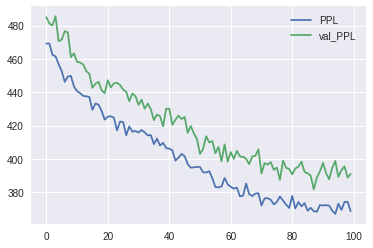

In [23]:
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [0]:
def predict_seq()

In [0]:
!ls ./drive/share_with_me/AI/Character-aware_LM/model

In [0]:
path_model = local_path + 'model/model.keras'
model.save(path_model)

In [0]:
from tensorflow.python.keras.models import load_model

model_restore = load_model(path_model, custom_objects={'ACC':ACC,'PPL': PPL})

In [42]:
hist = model_restore.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=30,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/30
50/50 [==============================] - 33s 653ms/step - loss: 5.8944 - ACC: 0.1480 - PPL: 363.5263 - val_loss: 5.9605 - val_ACC: 0.1466 - val_PPL: 388.1917
Epoch 2/30
50/50 [==============================] - 32s 635ms/step - loss: 5.8861 - ACC: 0.1497 - PPL: 360.2158 - val_loss: 5.9518 - val_ACC: 0.1464 - val_PPL: 384.9990
Epoch 3/30
50/50 [==============================] - 32s 635ms/step - loss: 5.8930 - ACC: 0.1480 - PPL: 362.9598 - val_loss: 5.9393 - val_ACC: 0.1465 - val_PPL: 380.1777
Epoch 4/30
50/50 [==============================] - 32s 634ms/step - loss: 5.8879 - ACC: 0.1489 - PPL: 361.0001 - val_loss: 5.9540 - val_ACC: 0.1472 - val_PPL: 385.8053
Epoch 5/30
33/50 [==================>...........] - ETA: 8s - loss: 5.8697 - ACC: 0.1503 - PPL: 354.6634

50/50 [==============================] - 32s 637ms/step - loss: 5.8765 - ACC: 0.1500 - PPL: 357.1124 - val_loss: 5.9506 - val_ACC: 0.1464 - val_PPL: 384.4385
Epoch 6/30
50/50 [==============================] - 32s 633ms/step - loss: 5.8776 - ACC: 0.1486 - PPL: 357.2971 - val_loss: 5.9781 - val_ACC: 0.1419 - val_PPL: 395.2691
Epoch 7/30
50/50 [==============================] - 32s 635ms/step - loss: 5.9062 - ACC: 0.1479 - PPL: 367.8513 - val_loss: 5.9615 - val_ACC: 0.1436 - val_PPL: 388.5396
Epoch 8/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8886 - ACC: 0.1490 - PPL: 361.5197 - val_loss: 5.9478 - val_ACC: 0.1472 - val_PPL: 383.2438
Epoch 9/30
41/50 [=======================>......] - ETA: 4s - loss: 5.8984 - ACC: 0.1479 - PPL: 364.7877

50/50 [==============================] - 32s 637ms/step - loss: 5.8958 - ACC: 0.1483 - PPL: 363.8770 - val_loss: 5.9494 - val_ACC: 0.1466 - val_PPL: 383.8188
Epoch 10/30
50/50 [==============================] - 32s 635ms/step - loss: 5.8862 - ACC: 0.1486 - PPL: 360.5114 - val_loss: 5.9527 - val_ACC: 0.1477 - val_PPL: 385.2807
Epoch 11/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8865 - ACC: 0.1487 - PPL: 360.6335 - val_loss: 5.9501 - val_ACC: 0.1461 - val_PPL: 384.1169
Epoch 12/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8919 - ACC: 0.1490 - PPL: 362.6028 - val_loss: 5.9615 - val_ACC: 0.1461 - val_PPL: 388.6056
Epoch 13/30
41/50 [=======================>......] - ETA: 4s - loss: 5.8776 - ACC: 0.1498 - PPL: 357.3819

50/50 [==============================] - 32s 635ms/step - loss: 5.8836 - ACC: 0.1490 - PPL: 359.5418 - val_loss: 5.9506 - val_ACC: 0.1453 - val_PPL: 384.6296
Epoch 14/30
50/50 [==============================] - 32s 634ms/step - loss: 5.8755 - ACC: 0.1496 - PPL: 356.6908 - val_loss: 5.9354 - val_ACC: 0.1472 - val_PPL: 378.6008
Epoch 15/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8845 - ACC: 0.1481 - PPL: 359.8402 - val_loss: 5.9467 - val_ACC: 0.1477 - val_PPL: 383.1359
Epoch 16/30
50/50 [==============================] - 32s 635ms/step - loss: 5.8851 - ACC: 0.1507 - PPL: 360.0210 - val_loss: 5.9669 - val_ACC: 0.1446 - val_PPL: 391.1294
Epoch 17/30
41/50 [=======================>......] - ETA: 4s - loss: 5.8959 - ACC: 0.1494 - PPL: 364.0701

50/50 [==============================] - 32s 634ms/step - loss: 5.8939 - ACC: 0.1491 - PPL: 363.3902 - val_loss: 5.9536 - val_ACC: 0.1467 - val_PPL: 385.6182
Epoch 18/30
50/50 [==============================] - 32s 637ms/step - loss: 5.8799 - ACC: 0.1503 - PPL: 358.2135 - val_loss: 5.9393 - val_ACC: 0.1484 - val_PPL: 380.2020
Epoch 19/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8767 - ACC: 0.1506 - PPL: 357.2579 - val_loss: 5.9556 - val_ACC: 0.1460 - val_PPL: 386.3647
Epoch 20/30
50/50 [==============================] - 32s 637ms/step - loss: 5.8725 - ACC: 0.1506 - PPL: 355.4810 - val_loss: 5.9593 - val_ACC: 0.1446 - val_PPL: 387.9375
Epoch 21/30
41/50 [=======================>......] - ETA: 4s - loss: 5.8835 - ACC: 0.1485 - PPL: 359.5713

50/50 [==============================] - 32s 634ms/step - loss: 5.8784 - ACC: 0.1488 - PPL: 357.7268 - val_loss: 5.9524 - val_ACC: 0.1462 - val_PPL: 385.2082
Epoch 22/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8830 - ACC: 0.1498 - PPL: 359.4412 - val_loss: 5.9483 - val_ACC: 0.1487 - val_PPL: 383.6383
Epoch 23/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8701 - ACC: 0.1497 - PPL: 354.6169 - val_loss: 5.9658 - val_ACC: 0.1452 - val_PPL: 390.6079
Epoch 24/30
50/50 [==============================] - 32s 635ms/step - loss: 5.8876 - ACC: 0.1492 - PPL: 361.1778 - val_loss: 5.9478 - val_ACC: 0.1477 - val_PPL: 383.3727
Epoch 25/30
41/50 [=======================>......] - ETA: 4s - loss: 5.8950 - ACC: 0.1495 - PPL: 363.7785

50/50 [==============================] - 32s 635ms/step - loss: 5.8902 - ACC: 0.1498 - PPL: 361.9596 - val_loss: 5.9550 - val_ACC: 0.1467 - val_PPL: 385.9793
Epoch 26/30
50/50 [==============================] - 32s 636ms/step - loss: 5.8681 - ACC: 0.1509 - PPL: 354.0137 - val_loss: 5.9525 - val_ACC: 0.1443 - val_PPL: 385.1356
Epoch 27/30
50/50 [==============================] - 32s 632ms/step - loss: 5.8737 - ACC: 0.1502 - PPL: 356.1157 - val_loss: 5.9327 - val_ACC: 0.1485 - val_PPL: 377.6034
Epoch 28/30
50/50 [==============================] - 32s 638ms/step - loss: 5.8741 - ACC: 0.1507 - PPL: 356.1445 - val_loss: 5.9569 - val_ACC: 0.1484 - val_PPL: 386.9351
Epoch 29/30
41/50 [=======================>......] - ETA: 4s - loss: 5.8725 - ACC: 0.1516 - PPL: 355.6296

50/50 [==============================] - 32s 639ms/step - loss: 5.8764 - ACC: 0.1509 - PPL: 357.0089 - val_loss: 5.9449 - val_ACC: 0.1471 - val_PPL: 382.2111
Epoch 30/30
50/50 [==============================] - 32s 638ms/step - loss: 5.8802 - ACC: 0.1514 - PPL: 358.3423 - val_loss: 5.9568 - val_ACC: 0.1458 - val_PPL: 386.9660


Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


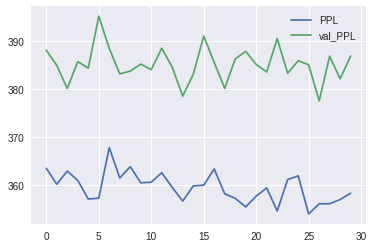

In [43]:
history = pd.DataFrame(hist.history)
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [0]:
X,Y = next(gen_word_word(batch_size=1, dataset='valid'))
X = list(X[0])
' '.join([id_to_word[id] for id in X])